# Building the EchoScope Model - 2

In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from collections import Counter

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
writer = SummaryWriter(log_dir="runs/spectrogram_exp_1")

In [4]:
IQ_Processed = np.load('../data/processed_iq_data.npz')
Spectrogram_Processed = np.load('../data/spectrograms.npz')

In [5]:
X_list = []
y_list = []

for key_str in IQ_Processed.files:
    key = ast.literal_eval(key_str)
    mod_name = key[0]
    data = IQ_Processed[key_str]
    
    X_list.append(data)
    y_list.extend([mod_name] * data.shape[0])

X = np.vstack(X_list)
y = np.array(y_list)

print(f'Total samples: {X.shape[0]}')
print(f'Unique modulations: {np.unique(y)}')
unique_modulations = np.unique(y)

Total samples: 220000
Unique modulations: ['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']


In [6]:
def split_sets(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
    
    print(f'Train shape: {X_train.shape}, {y_train.shape}')
    print(f'Validation shape: {X_val.shape}, {y_val.shape}')
    print(f'Test shape: {X_test.shape}, {y_test.shape}')
    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = split_sets(X, y)

Train shape: (132000, 2, 128), (132000,)
Validation shape: (44000, 2, 128), (44000,)
Test shape: (44000, 2, 128), (44000,)


In [8]:
LE = LabelEncoder()
y_train_enc = LE.fit_transform(y_train)
y_val_enc = LE.transform(y_val)
y_test_enc = LE.transform(y_test)

print(LE.classes_)

['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']


In [9]:
train_dataset_time = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_enc, dtype=torch.long))
val_dataset_time = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val_enc, dtype=torch.long))
test_dataset_time = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_enc, dtype=torch.long))

train_loader_time = DataLoader(train_dataset_time, batch_size=64, shuffle=True)
val_loader_time = DataLoader(val_dataset_time, batch_size=64, shuffle=False)
test_loader_time = DataLoader(test_dataset_time, batch_size=64, shuffle=False)

In [10]:
class Time_Series_Model(nn.Module):
    def __init__(self, input_size=128, hidden_size=32, output_size=11, num_layers=1, dropout=0.5):
        super(Time_Series_Model, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0.0  
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.dropout(last_out)
        out = self.fc(out)
        return out

In [11]:
Time_Series_Model_V1 = Time_Series_Model()
Time_Series_Model_V1 = Time_Series_Model_V1.to(device)

In [12]:
def set_seed(seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

In [13]:
import copy

def train_model(model, criterion, optimizer, epochs, train_loader, val_loader, patience=5, scheduler=None):
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0
    
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("LR", optimizer.param_groups[0]['lr'], epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch} (best val loss: {best_val_loss:.6f})")
                break
        if scheduler:
            scheduler.step(val_loss)
            
    model.load_state_dict(best_model_state)
    return train_losses, val_losses


In [14]:
optimizer = optim.Adam(Time_Series_Model_V1.parameters(), lr=0.0001)
train_losses, val_losses = train_model(model=Time_Series_Model_V1, criterion=nn.CrossEntropyLoss(), 
            optimizer=optimizer, epochs=50, train_loader=train_loader_time, 
            val_loader=val_loader_time)

KeyboardInterrupt: 

### Hyperparameter Trials: 

#### Trial 1: Complex model w/o dropout
The model overfitted with the following hyperparameters: input_size=128, hidden_size=64, output_size=11, num_layers=1, dropout=0, learning_rate=0.0001, optimizer=Adam, loss_fn=CrossEntropyLoss, epochs=50, using a bidirectional LSTM without effective dropout due to num_layers=1.

#### Trial 2: Complex model w/ dropout
The model previously overfitted using the following configuration: input_size=128, hidden_size=64, output_size=11, num_layers=2, dropout=0.5, bidirectional=True, learning_rate=0.0001, optimizer=Adam, and CrossEntropyLoss. Despite enabling both internal and external dropout, validation loss steadily increased while training loss decreased, indicating the model capacity was too high for the dataset. This prompted a simplification of the architecture to reduce overfitting risk.

#### Trial 3: Simplified model w/dropout
The simplified model (input_size=128, hidden_size=32, output_size=11, num_layers=1, dropout=0.5, bidirectional=False, learning_rate=0.0001) showed significantly improved generalization compared to the previous overfitted configuration. Both training and validation loss decreased steadily over 50 epochs, confirming that reducing model complexity effectively mitigated overfitting and led to stable convergence.

In [18]:
epochs = range(1, 51)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 1000x600 with 0 Axes>

In [14]:
keys = Spectrogram_Processed.files
print(keys)

key_example = "('QPSK', 2)"
if key_example in keys:
    data = Spectrogram_Processed[key_example]
    print(f"Data shape for {key_example}:", data.shape)
else:
    print(f"{key_example} not found in the file.")

["('QPSK', 2)", "('PAM4', 8)", "('AM-DSB', -4)", "('GFSK', 6)", "('QAM64', 8)", "('AM-SSB', 12)", "('8PSK', 8)", "('8PSK', 12)", "('QAM64', -6)", "('QAM16', 2)", "('QAM16', -20)", "('PAM4', -6)", "('WBFM', -18)", "('AM-DSB', 16)", "('CPFSK', 10)", "('WBFM', 6)", "('BPSK', 4)", "('BPSK', -2)", "('QPSK', -20)", "('CPFSK', -8)", "('AM-SSB', 6)", "('QAM64', -20)", "('QAM16', 12)", "('GFSK', -20)", "('AM-SSB', -12)", "('CPFSK', 0)", "('AM-DSB', 6)", "('BPSK', -16)", "('QPSK', -6)", "('8PSK', -12)", "('CPFSK', -18)", "('BPSK', -10)", "('QPSK', 8)", "('PAM4', 14)", "('AM-DSB', -10)", "('GFSK', 12)", "('QAM64', 2)", "('WBFM', -4)", "('AM-SSB', -18)", "('QAM64', -4)", "('GFSK', -4)", "('AM-DSB', 8)", "('PAM4', -16)", "('QPSK', -16)", "('BPSK', 16)", "('8PSK', -8)", "('CPFSK', 16)", "('WBFM', 0)", "('QPSK', 6)", "('BPSK', 14)", "('AM-DSB', -8)", "('GFSK', -10)", "('CPFSK', -2)", "('AM-SSB', 8)", "('GFSK', 18)", "('QAM16', 6)", "('QAM16', -16)", "('QAM64', 18)", "('AM-SSB', -2)", "('CPFSK', 6)", 

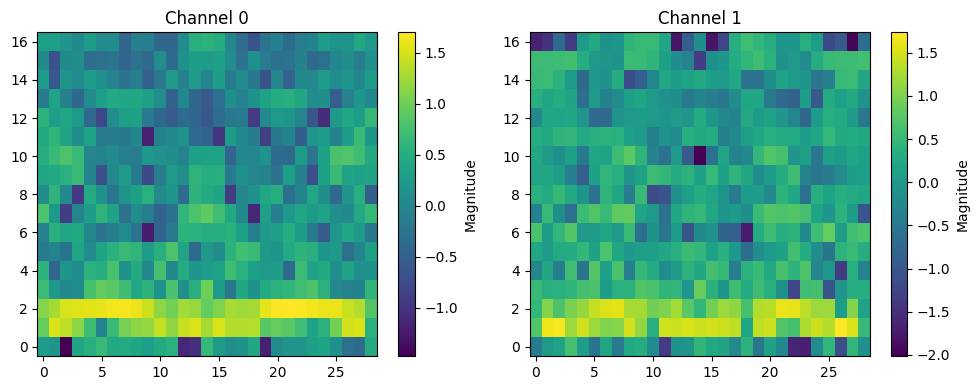

In [15]:
example = data[0] 
plt.figure(figsize=(10,4))
for ch in range(example.shape[0]):
    plt.subplot(1, 2, ch+1)
    plt.title(f'Channel {ch}')
    plt.imshow(example[ch], aspect='auto', origin='lower')
    plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

In [16]:
mod_to_group = {
    'QAM16': 'QAM',
    'QAM64': 'QAM',
    'BPSK': 'PSK',
    'QPSK': 'PSK',
    '8PSK': 'PSK',
    'AM-DSB': 'AM',
    'AM-SSB': 'AM',
    'CPFSK': 'FSK',
    'GFSK': 'FSK',
    'WBFM': 'FM',
    'PAM4': 'PAM',
}
unique_groups = sorted(set(mod_to_group.values()))
group_to_idx = {group: i for i, group in enumerate(unique_groups)}

print(f"Group map: {group_to_idx}")

Group map: {'AM': 0, 'FM': 1, 'FSK': 2, 'PAM': 3, 'PSK': 4, 'QAM': 5}


In [17]:
all_data_spect = []
all_labels_spect = []

keys_tuples = [eval(k) if isinstance(k, str) else k for k in Spectrogram_Processed.keys()]

for key in keys_tuples:
    modulation = key[0]
    group = mod_to_group[modulation]
    str_key = str(key)
    data = Spectrogram_Processed[str_key]
    all_data_spect.append(data)

    label_idx = group_to_idx[group]
    labels = np.full(data.shape[0], label_idx)
    all_labels_spect.append(labels)

X = np.concatenate(all_data_spect, axis=0)
y = np.concatenate(all_labels_spect, axis=0)

print(f"Combined data shape: {X.shape}")
print(f"Combined labels shape: {y.shape}")

Combined data shape: (220000, 2, 17, 29)
Combined labels shape: (220000,)


In [18]:
X_train, y_train, X_val, y_val, X_test, y_test = split_sets(X, y)

Train shape: (132000, 2, 17, 29), (132000,)
Validation shape: (44000, 2, 17, 29), (44000,)
Test shape: (44000, 2, 17, 29), (44000,)


In [19]:
LE = LabelEncoder()
y_train_enc = LE.fit_transform(y_train)
y_val_enc = LE.transform(y_val)
y_test_enc = LE.transform(y_test)
print(Counter(y_train_enc))
print(LE.classes_)

Counter({np.int64(4): 36000, np.int64(5): 24000, np.int64(2): 24000, np.int64(0): 24000, np.int64(3): 12000, np.int64(1): 12000})
[0 1 2 3 4 5]


In [20]:
train_dataset_spect = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_enc, dtype=torch.long))
val_dataset_spect = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val_enc, dtype=torch.long))
test_dataset_spect = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_enc, dtype=torch.long))

train_loader_spect = DataLoader(train_dataset_spect, batch_size=64, shuffle=True)
val_loader_spect = DataLoader(val_dataset_spect, batch_size=64, shuffle=False)
test_loader_spect = DataLoader(test_dataset_spect, batch_size=64, shuffle=False)

In [21]:
class SpectrogramPatchEncoder(nn.Module):
    def __init__(self, in_channels=2, patch_size=(1, 1), embed_dim=128, img_size=(17, 29)):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x) 
        x = x.flatten(2).transpose(1, 2)

        cls_tokens = self.cls_token.expand(B, -1, -1)

        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed

        return x

In [22]:
class SpectrogramModel(nn.Module):
    def __init__(self, in_channels=2, img_size=(17, 29), patch_size=(3, 3), embed_dim=256, num_classes=11):
        super().__init__()
        self.patch_encoder = SpectrogramPatchEncoder(
            in_channels=in_channels,
            patch_size=patch_size,
            embed_dim=embed_dim,
            img_size=img_size
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=8, dim_feedforward=512, batch_first=True),
            num_layers=4
        )
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(0.5),
            nn.Linear(embed_dim, num_classes)
        )
    def forward(self, x):
        x = self.patch_encoder(x)
        x = self.transformer(x)
        x = x[:, 0]
        x = self.classifier(x)
        return x
        

In [23]:
class CNN_SpectrogramModel(nn.Module):
    def __init__(self, in_channels=2, num_classes=11):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [24]:
classes = np.unique(y)
class_weights = torch.tensor([0.8, 1.4, 1.4, 1.8, 1, 1.3]) 
class_weights_tensor = class_weights.to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.8000, 1.4000, 1.4000, 1.8000, 1.0000, 1.3000])


In [25]:
CNNSpectrogramModelV1 = CNN_SpectrogramModel(in_channels=2, num_classes=6).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(CNNSpectrogramModelV1.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [26]:
train_losses_spect, val_losses_spect = train_model(model=CNNSpectrogramModelV1, criterion=criterion, 
            optimizer=optimizer, epochs=15, train_loader=train_loader_spect, 
            val_loader=val_loader_spect, scheduler=scheduler)

Epoch 1/15 | Train Loss: 1.094401 | Val Loss: 1.025158
Epoch 2/15 | Train Loss: 0.999236 | Val Loss: 1.003048
Epoch 3/15 | Train Loss: 0.958320 | Val Loss: 0.987412
Epoch 4/15 | Train Loss: 0.934500 | Val Loss: 0.935926
Epoch 5/15 | Train Loss: 0.916042 | Val Loss: 0.969451
Epoch 6/15 | Train Loss: 0.902160 | Val Loss: 0.934363


KeyboardInterrupt: 

In [27]:
CNNSpectrogramModelV1.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader_spect:
        X_batch = X_batch.to(device)
        outputs = CNNSpectrogramModelV1(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

print(classification_report(y_true, y_pred, target_names=[str(c) for c in LE.classes_]))

              precision    recall  f1-score   support

           0       0.42      0.43      0.43      8000
           1       0.56      0.53      0.54      4000
           2       0.60      0.69      0.64      8000
           3       0.81      0.58      0.68      4000
           4       0.53      0.48      0.50     12000
           5       0.59      0.69      0.64      8000

    accuracy                           0.56     44000
   macro avg       0.59      0.57      0.57     44000
weighted avg       0.56      0.56      0.56     44000



In [27]:
Spectrogram_Model_V1 = SpectrogramModel(in_channels=2, img_size=(17, 29), patch_size=(3, 3), embed_dim=256,
                                                 num_classes=6).to(device)

In [30]:
optimizer = optim.Adam(Spectrogram_Model_V1.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
train_losses_spect, val_losses_spect = train_model(model=Spectrogram_Model_V1, criterion=criterion, 
            optimizer=optimizer, epochs=15, train_loader=train_loader_spect, 
            val_loader=val_loader_spect, scheduler=scheduler)

Epoch 1/15 | Train Loss: 0.885547 | Val Loss: 0.897001
Epoch 2/15 | Train Loss: 0.883889 | Val Loss: 0.882648
Epoch 3/15 | Train Loss: 0.880455 | Val Loss: 0.876217
Epoch 4/15 | Train Loss: 0.878984 | Val Loss: 0.920678
Epoch 5/15 | Train Loss: 0.877456 | Val Loss: 0.889465
Epoch 6/15 | Train Loss: 0.874503 | Val Loss: 0.873555
Epoch 7/15 | Train Loss: 0.873197 | Val Loss: 0.871389
Epoch 8/15 | Train Loss: 0.871761 | Val Loss: 0.871016
Epoch 9/15 | Train Loss: 0.869496 | Val Loss: 0.889752
Epoch 10/15 | Train Loss: 0.868104 | Val Loss: 0.882432
Epoch 11/15 | Train Loss: 0.866242 | Val Loss: 0.878178
Epoch 12/15 | Train Loss: 0.866253 | Val Loss: 0.875672
Epoch 13/15 | Train Loss: 0.845004 | Val Loss: 0.855926
Epoch 14/15 | Train Loss: 0.841856 | Val Loss: 0.857433
Epoch 15/15 | Train Loss: 0.839230 | Val Loss: 0.864741


In [31]:
Spectrogram_Model_V1.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader_spect:
        X_batch = X_batch.to(device)
        outputs = Spectrogram_Model_V1(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

print(classification_report(y_true, y_pred, target_names=[str(c) for c in LE.classes_]))

              precision    recall  f1-score   support

           0       0.42      0.55      0.47      8000
           1       0.57      0.52      0.54      4000
           2       0.76      0.66      0.71      8000
           3       0.85      0.66      0.74      4000
           4       0.58      0.61      0.60     12000
           5       0.75      0.67      0.71      8000

    accuracy                           0.62     44000
   macro avg       0.65      0.61      0.63     44000
weighted avg       0.64      0.62      0.62     44000



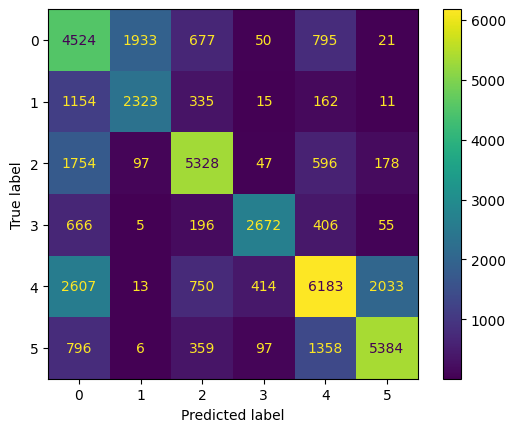

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=LE.classes_).plot()

The spectrogram transformer model was trained with patch_size=(3, 3), embed_dim=128, 4 transformer layers, and 8 attention heads using the Adam optimizer (lr=1e-4) over a maximum of 50 epochs with early stopping (patience=5).
The best validation loss achieved was 1.6093, occurring at Epoch 12, after which performance plateaued and slightly degraded, indicating early signs of overfitting. This model achieved an accuracy of 39%. 

With in_channels=2, patch size (1, 1), and an embedding dimension of 256, the Spectrogram Transformer model trained over 50 epochs achieved a plateau in validation loss around epoch 20, indicating the need for architectural or regularization improvements to further enhance generalization.

We trained a multi-class classification model on spectrogram data using a patch-based encoder with early stopping. Using current hyperparameters, the model achieved a validation loss of 1.5028, with a final test accuracy of 43%, and best per-class F1-scores in the range of 0.66–0.72 for 4 out of 11 classes, indicating strong performance on some signal types but difficulties with others (notably classes 1, 2, 7, and 10).

Spectrograms were standardized using global channel-wise mean and standard deviation. The model employed a patch encoder with a patch size of (1, 2) and an embedding dimension of 256. A 4-layer Transformer with 8 attention heads and a feedforward dimension of 256 was used for feature extraction. Classification was performed using a LayerNorm, dropout of 0.3, and a final linear layer outputting 11 classes. Training used CrossEntropyLoss with label smoothing (0.1) and class weights to handle imbalance, optimized with Adam (learning rate 1e-4, weight decay 1e-4), and a ReduceLROnPlateau scheduler. After 25 epochs, the model achieved 50% test accuracy, outperforming the previous best by 7%, even without Gaussian noise or other augmentations. After further testing, the model stopped early after train loss surpassed val loss by a large value around epoch 31. 

The model trained for 38 epochs with Gaussian noise augmentation (mean 0, std 0.05) on spectrogram inputs achieved about 49% accuracy, a slight drop from the baseline 50% without noise. Despite this, key classes maintained strong recall, notably class 2 at 95%, and mid-performing classes (3–6) kept solid F1 scores between 0.65 and 0.72. Importantly, recall for difficult classes like 7 improved from 7% to 15%, showing increased robustness. This indicates that adding Gaussian noise helps the model generalize better, particularly on challenging classes, and with longer training or additional augmentations, further gains are likely.

Using the same hyperparameters as our previous experiment, we trained the model off a spectrogram model with dimensions of (33, 13), achieving a 43% accuracy. Model took noticably longer to train. 

Dim_feedforward increased to 512 and patch size increased to (3, 3). Accuracy moved up to 45% off 25 epochs. At 32 epochs, the model stopped early due to overfitting, but ended with an accuracy of 47%. 

Model early stopped at epoch 21 and performed with a 37% accuracy when dimensionality was (65, 5)

With a dimensionality of (17, 29), model early stopped at epoch 32, but had a 51% accuracy, breaking the previous record. Despite having a relatively coarse patch size of (3, 3), the model outperformed the previous recordholder, suggesting spectrogram processing may be the core issue of the model's somewhat low accuracy. For these next trials, model will be trained with a finer patch size + higher dropout (dropout currently at 0.3). 

When dimensionality was increased to (17, 125), model had accuracy of 51% after 15 epochs w/ a patch size of (4, 4). The lack of change despite the suprising increase in dimension size may suggest something inherently wrong with the model or training data itself. Next trial will be using same hyperparameters with an image size of (33, 61).

With an image size of (33, 61), model performed much worse, achieving an accuracy of 43%. 

Given the scale and variants our data has gone through with minimal change, we will try to use a basic CNN for processing opposed to our previously used vit. 

Our CNN model performed with a 50% accuracy, and given our confusion matrix, it's likely that we are hitting a data ceiling, not necessarily an architectural one. It is likely our classes are often too similar to differentiate, so we will be binning our classes, reducing the quantity from 
11 -> 6. 
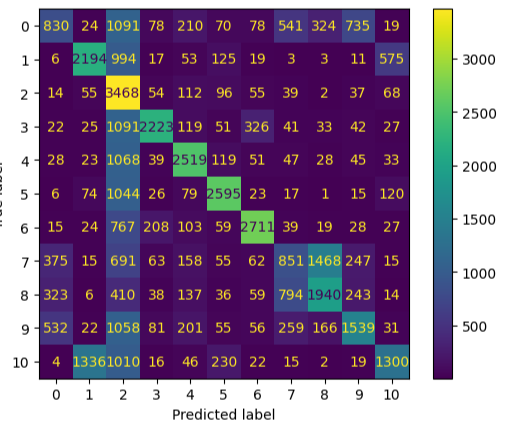

After group binning, our CNN was able to achieve a 58% accuracy, and our transformer was able to reach 61%. Further testing on different spectrogram resolutions will take place, as our current statistics were done with dimensions of (17, 125). 

With dimensions of (17, 29), CNN scored 56% and transformer scored 60%. 

After counting the class distribution, it seems as though class 4 is overrepresented. Trials will be ran in cases where class 4's impact is limited. 

Trials were ran in which class 4's weight was dynamically changed, but accuracy still remained the same for both models. When looking at class 0, it seems as though there are 8k+ false positives for it. Action will be taken to classify spectrograms as 0 less often. 

With updated weights of ([1.0, 1.5, 1.0, 1.2, 2.0, 1.2]), train and val loss reached all time lows. However, class 4 overprediction was quite obvious within the model, indicated by this matrix. 

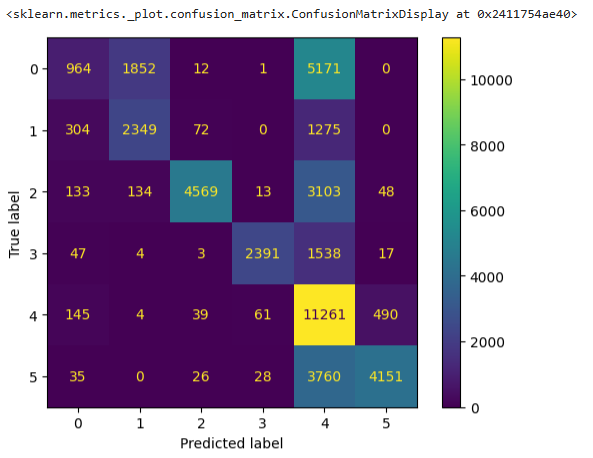

Lowering class 4's weight influence will be the go-to route for these next trials. 